# Lab | Making predictions with logistic regression
In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

## Instructions
    1) Create a query or queries to extract the information you think may be relevant for building the prediction model.  It should include some film features and some rental features.
    2) Read the data into a Pandas dataframe.
    3) Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.
    4) Create a logistic regression model to predict this variable from the cleaned data.
    5) Evaluate the results.

In [31]:
import getpass
import pandas as pd
import pymysql
import seaborn as sns
import sqlalchemy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import normaltest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
password = getpass.getpass()
connection_string = 'mysql+pymysql://annamst:' + password + '@localhost/bank'
engine = sqlalchemy.create_engine(connection_string)
engine.execute("USE sakila_copy_lab")

········


### Getting the data from SQL queries. 
#### I already joined all needed queries in form of views in MySQL, so now I need only one query of that join to export to Python.

In [3]:
query = """SELECT rating, length, copies_available, category_name, count_popular_actors, times_rented_last_month, if_film_rented from rating
INNER JOIN length ON rating.film_id = length.film_id
INNER JOIN number_copies ON length.film_id = number_copies.film_id
INNER JOIN category_of_film ON number_copies.film_id = category_of_film.film_id
INNER JOIN film_count_pop_actors ON category_of_film.film_id = film_count_pop_actors.film_id 
INNER JOIN num_rentals_last_mo ON film_count_pop_actors.film_id = num_rentals_last_mo.film_id 
INNER JOIN rented_this_month_y_n ON  num_rentals_last_mo.film_id = rented_this_month_y_n.film_id
ORDER BY rating.film_id"""

data = pd.read_sql_query(query, engine)
data.head()

,rating,length,copies_available,category_name,count_popular_actors,times_rented_last_month,if_film_rented
0,PG,86,8,Documentary,16.0,1,YES
1,G,48,3,Horror,6.0,0,NO
2,NC-17,50,4,Documentary,4.0,0,YES
3,G,117,7,Horror,14.0,1,YES
4,G,130,3,Family,3.0,1,YES


### Data exploration and checking for nulls

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rating                   955 non-null    object 
 1   length                   955 non-null    int64  
 2   copies_available         955 non-null    int64  
 3   category_name            955 non-null    object 
 4   count_popular_actors     955 non-null    float64
 5   times_rented_last_month  955 non-null    int64  
 6   if_film_rented           955 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 52.4+ KB


#### The info shows that there is no null values in the data and the length of every column is the same.

In [5]:
data['if_film_rented'].value_counts()

YES    897
NO      58
Name: if_film_rented, dtype: int64

#### There is a huge imbalance in the representation of the two categories.

In [6]:
# checking unique values for categorical variables to check for duality due to misspellings etc
data['rating'].value_counts()

PG-13    213
NC-17    202
R        187
PG       183
G        170
Name: rating, dtype: int64

In [7]:
data['category_name'].value_counts()

Sports         72
Family         67
Foreign        67
Animation      64
Documentary    63
Action         61
Drama          60
New            60
Sci-Fi         59
Games          58
Children       58
Comedy         56
Classics       54
Horror         53
Travel         52
Music          51
Name: category_name, dtype: int64

#### It seems that everything is fine with categorical columns, no need for data cleaning.

In [8]:
# Checking the numerical data for outliers, need for scaling, etc

data.describe()

,length,copies_available,count_popular_actors,times_rented_last_month
count,955.000000,955.000000,955.000000,955.000000
mean,115.363351,4.783246,9.102618,0.872251
std,40.430401,1.817724,7.640778,0.905616
min,46.000000,2.000000,0.000000,0.000000
25%,80.000000,3.000000,4.000000,0.000000
50%,114.000000,5.000000,7.000000,1.000000
75%,149.500000,6.000000,12.000000,1.000000
max,185.000000,8.000000,56.000000,5.000000


In [9]:
data.corr()

,length,copies_available,count_popular_actors,times_rented_last_month
length,1.000000,-0.037210,-0.021861,-0.011041
copies_available,-0.037210,1.000000,0.470511,0.328925
count_popular_actors,-0.021861,0.470511,1.000000,0.107179
times_rented_last_month,-0.011041,0.328925,0.107179,1.000000


#### There is no need for scaling data, so we will use that data to train a model without transformations. There is also no need of deleting columns, because we don't see any significant corelation between columns.

### Getting the numerical columns

In [10]:
numcols = data.select_dtypes(np.number)
numcols.head()

,length,copies_available,count_popular_actors,times_rented_last_month
0,86,8,16.0,1
1,48,3,6.0,0
2,50,4,4.0,0
3,117,7,14.0,1
4,130,3,3.0,1


### Categorical columns

The categorical columns are:  ['rating', 'category_name', 'if_film_rented']

Frequency analysis of column:  rating

Frequency analysis of column:  category_name

Frequency analysis of column:  if_film_rented



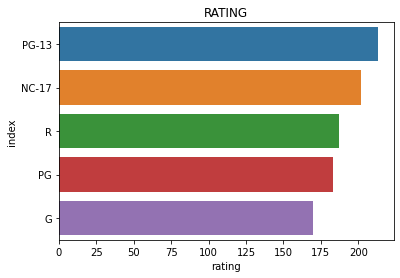

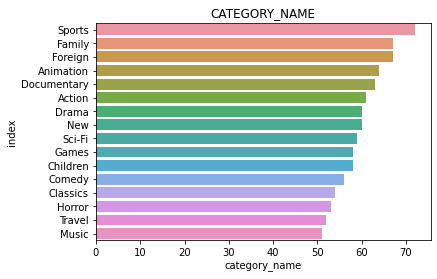

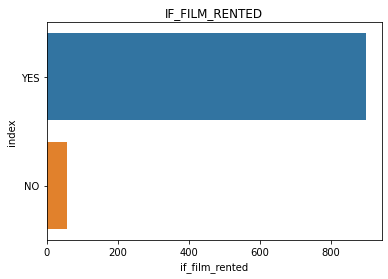

<Figure size 432x288 with 0 Axes>

In [11]:
# Checking all the categorical columns
cols_cat = list(data.select_dtypes(include=['object']).columns)

print("The categorical columns are: ",cols_cat)
print("========================================")
print()

for col in cols_cat:
    print("Frequency analysis of column: ",col)
    my_data = data[col].value_counts().reset_index()
    ax = sns.barplot(x=col, y="index", data = my_data).set_title(col.upper())
    plt.figure()
    print()

### Dummifying categorical columns

In [12]:
cat = data.select_dtypes(include = np.object)
cat = cat.drop(['if_film_rented'], axis=1)
objects_dummyfied = pd.get_dummies(cat)
display(objects_dummyfied.head())
display(objects_dummyfied.shape)

,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_name_Action,category_name_Animation,category_name_Children,category_name_Classics,category_name_Comedy,...,category_name_Drama,category_name_Family,category_name_Foreign,category_name_Games,category_name_Horror,category_name_Music,category_name_New,category_name_Sci-Fi,category_name_Sports,category_name_Travel
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


(955, 21)

### Concatenating numerical and categorical variables to get a full set of independent values.

In [13]:
X_independent = pd.concat([objects_dummyfied, numcols], axis = 1)

### X/Y split

In [14]:
y_dependent = data['if_film_rented']

### Train-test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_independent, y_dependent, test_size=0.3, random_state = 100)

### Modeling and Model Validation

In [19]:
classification = LogisticRegression(random_state=0, solver='lbfgs',  max_iter=500).fit(X_train, y_train)
y_pred = classification.predict(X_test)
print("The accuracy of the logistic_regression model is: %4.2f "% (classification.score(X_test, y_test)))

The accuracy of the logistic_regression model is: 0.94 


The accuracy of the model on test set is: 0.94 
[[  0  17]
 [  0 270]]


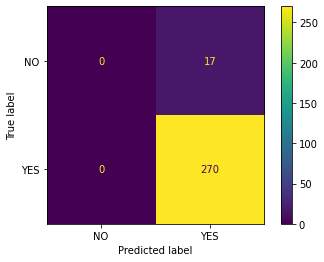

The Kappa of your model is: 0.00
              precision    recall  f1-score   support

         YES       0.94      1.00      0.97       270
          NO       0.00      0.00      0.00        17

    accuracy                           0.94       287
   macro avg       0.47      0.50      0.48       287
weighted avg       0.89      0.94      0.91       287



/home/annast/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(classification, X_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, labels=['YES','NO']))

### Due to severe data imbalance in the dependent variable value counts, even though the accuracy of the model  is high - the model has never correcly predicted a NO value.

# But let's try to deal with data imbalance and improve the model!

### 1) By scaling the numerical features

In [26]:
transformer = StandardScaler().fit(numcols)
scaled_num = transformer.transform(numcols)
scaled_num = pd.DataFrame(scaled_num)

In [27]:
X_independent = pd.concat([objects_dummyfied, scaled_num], axis = 1)

The accuracy of the logistic_regression model is: 0.94 
[[  0  17]
 [  0 270]]


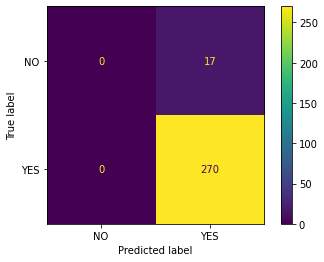

The Kappa of your model is: 0.00
              precision    recall  f1-score   support

         YES       0.94      1.00      0.97       270
          NO       0.00      0.00      0.00        17

    accuracy                           0.94       287
   macro avg       0.47      0.50      0.48       287
weighted avg       0.89      0.94      0.91       287



/home/annast/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_independent, y_dependent, test_size=0.3, random_state = 100)
classification = LogisticRegression(random_state=0, solver='lbfgs',  max_iter=500).fit(X_train, y_train)
y_pred = classification.predict(X_test)
print("The accuracy of the logistic_regression model is: %4.2f "% (classification.score(X_test, y_test)))
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(classification, X_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, labels=['YES','NO']))

#### The model is still bad :) 
#### But that is all only because of data imbalance then!

### 2) SMOTE oversampling

In [33]:
oversample = SMOTE()
transformer = StandardScaler().fit(X_independent)
Scaled_X = transformer.transform(X_independent)
X, y = oversample.fit_resample(X_independent, y_dependent)
counter = Counter(y)
print(counter)

Counter({'YES': 897, 'NO': 897})


The accuracy of the logistic_regression model is: 0.94 
[[256  11]
 [ 22 250]]


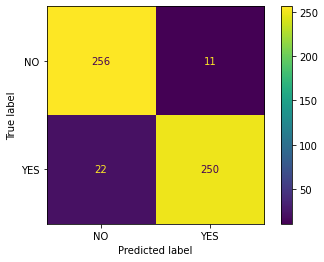

The Kappa of your model is: 0.88
              precision    recall  f1-score   support

         YES       0.96      0.92      0.94       272
          NO       0.92      0.96      0.94       267

    accuracy                           0.94       539
   macro avg       0.94      0.94      0.94       539
weighted avg       0.94      0.94      0.94       539



In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 100)
classification = LogisticRegression(random_state=0, solver='lbfgs',  max_iter=500).fit(X_train, y_train)
y_pred = classification.predict(X_test)
print("The accuracy of the logistic_regression model is: %4.2f "% (classification.score(X_test, y_test)))
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(classification, X_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, labels=['YES','NO']))

### WOW! The recall and kappa-score are amaxing now! SMOTE oversampling really facilitated the ability of the model to predict the minority class.